In [1]:
# Space Mission Data Analysis - Predictive Modeling

#This notebook focuses on building and evaluating machine learning models to predict space mission outcomes based on historical data.

## Setup

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%pip install joblib
import joblib
import os


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Machine learning libraries
%pip install scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Install xgboost if not already installed
%pip install xgboost

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import our custom modules
import sys
sys.path.append('../src')
from modeling import evaluate_model, plot_feature_importance, plot_model_comparison
from visualization import set_plotting_style


In [5]:
# Set plotting style
set_plotting_style()

In [6]:
# Create output directory if it doesn't exist
os.makedirs('./output/models', exist_ok=True)

In [7]:
## Load and Prepare Data

# Load the cleaned dataset
missions_df = pd.read_csv('./data/processed/missions_cleaned_final.csv')

# Handle date columns
date_columns = ['Launch_Date']
for col in date_columns:
    if col in missions_df.columns:
        missions_df[col] = pd.to_datetime(missions_df[col])

# Display basic info
print(f"Dataset shape: {missions_df.shape}")
missions_df.head()

Dataset shape: (4312, 14)


,Company,Location,Launch_Date,Mission_Detail,Rocket_Status,Rocket,Mission_Status,Launch_Year,Launch_Month,Launch_Day,Launch_DOY,Is_Successful,Mission_Age_Years,Launch_Decade
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success,2020.0,8.0,7.0,220.0,1,5.0,2020.0
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,2020.0,8.0,6.0,219.0,1,5.0,2020.0
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,Unknown,Success,2020.0,8.0,4.0,217.0,1,5.0,2020.0
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success,2020.0,7.0,30.0,212.0,1,5.0,2020.0
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.0,Success,2020.0,7.0,30.0,212.0,1,5.0,2020.0


In [10]:
## Feature Engineering

# We'll create some additional features that might be useful for prediction

# Extract temporal features
missions_df['Launch_Year'] = missions_df['Launch_Date'].dt.year
missions_df['Launch_Month'] = missions_df['Launch_Date'].dt.month
missions_df['Launch_Day'] = missions_df['Launch_Date'].dt.day
missions_df['Launch_DayOfWeek'] = missions_df['Launch_Date'].dt.dayofweek

# Ensure the 'Agency' column exists
if 'Agency' not in missions_df.columns:
    print("'Agency' column is missing from the DataFrame. Adding a placeholder column with default values.")
    missions_df['Agency'] = 'Unknown'

# Agency experience: count of previous launches by the same agency
agency_experience = {}
missions_df['Agency_Experience'] = 0

# Sort by launch date
sorted_missions = missions_df.sort_values('Launch_Date')

# Calculate experience for each mission
for idx, row in sorted_missions.iterrows():
    agency = row['Agency']
    exp = agency_experience.get(agency, 0)
    sorted_missions.at[idx, 'Agency_Experience'] = exp
    agency_experience[agency] = exp + 1

# Update the original dataframe
missions_df = sorted_missions.copy()

# Success rate of previous missions by the same agency
agency_success_history = {}
missions_df['Agency_Prior_Success_Rate'] = 0.0

for idx, row in missions_df.iterrows():
    agency = row['Agency']
    missions_df.at[idx, 'Agency_Prior_Success_Rate'] = agency_success_history.get(agency, [0, 0])[0] / max(1, agency_success_history.get(agency, [0, 1])[1])
    
    # Update agency history
    success = 1 if row['Mission_Status'] == 'Success' else 0
    if agency not in agency_success_history:
        agency_success_history[agency] = [success, 1]
    else:
        agency_success_history[agency][0] += success
        agency_success_history[agency][1] += 1

# If available, create payload categories
if 'Payload_Mass_kg' in missions_df.columns:
    # Create payload mass categories
    bins = [0, 100, 500, 1000, 5000, float('inf')]
    labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
    missions_df['Payload_Category'] = pd.cut(missions_df['Payload_Mass_kg'], bins=bins, labels=labels)

# Create a binary target variable (Success or not)
missions_df['Success_Binary'] = (missions_df['Mission_Status'] == 'Success').astype(int)

# Display the engineered features
print("\nFeature engineering complete. New columns added:")
print(missions_df.columns.difference(pd.read_csv('./data/processed/missions_cleaned_final.csv').columns).tolist())
missions_df[['Launch_Year', 'Launch_Month', 'Launch_Day', 'Launch_DayOfWeek', 
             'Agency_Experience', 'Agency_Prior_Success_Rate', 'Success_Binary']].head()


'Agency' column is missing from the DataFrame. Adding a placeholder column with default values.

Feature engineering complete. New columns added:
['Agency', 'Agency_Experience', 'Agency_Prior_Success_Rate', 'Launch_DayOfWeek', 'Success_Binary']


,Launch_Year,Launch_Month,Launch_Day,Launch_DayOfWeek,Agency_Experience,Agency_Prior_Success_Rate,Success_Binary
4311,1957.0,10.0,4.0,4.0,0,0.000000,1
4310,1957.0,11.0,3.0,6.0,1,1.000000,1
4309,1957.0,12.0,6.0,4.0,2,1.000000,0
4308,1958.0,2.0,1.0,5.0,3,0.666667,1
4307,1958.0,2.0,5.0,2.0,4,0.750000,0


In [11]:
## Prepare Data for Modeling

# Define features and target
target = 'Success_Binary'

# Basic features available in most datasets
basic_features = ['Launch_Year', 'Launch_Month', 'Launch_Day', 'Launch_DayOfWeek', 
                 'Agency_Experience', 'Agency_Prior_Success_Rate']

# Categorical features to encode
categorical_features = ['Agency', 'Rocket']

# Additional features if available
additional_numerical_features = []
if 'Cost_Millions_USD' in missions_df.columns:
    additional_numerical_features.append('Cost_Millions_USD')
if 'Payload_Mass_kg' in missions_df.columns:
    additional_numerical_features.append('Payload_Mass_kg')

additional_categorical_features = []
if 'Orbit' in missions_df.columns:
    additional_categorical_features.append('Orbit')
if 'Mission_Purpose' in missions_df.columns:
    additional_categorical_features.append('Mission_Purpose')
if 'Launch_Site' in missions_df.columns:
    additional_categorical_features.append('Launch_Site')
if 'Payload_Category' in missions_df.columns:
    additional_categorical_features.append('Payload_Category')

# Combine all features
numerical_features = basic_features + additional_numerical_features
categorical_features = categorical_features + additional_categorical_features

# Print selected features
print("Selected features for modeling:")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")
print(f"Target variable: {target}")

Selected features for modeling:
Numerical features: ['Launch_Year', 'Launch_Month', 'Launch_Day', 'Launch_DayOfWeek', 'Agency_Experience', 'Agency_Prior_Success_Rate']
Categorical features: ['Agency', 'Rocket']
Target variable: Success_Binary


In [12]:
# Clean data: Remove rows with NaN in target
missions_df = missions_df.dropna(subset=[target])

# Split data into features and target
X = missions_df[numerical_features + categorical_features]
y = missions_df[target]

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

## Create Preprocessing Pipeline

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Bundle preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Training set shape: (3234, 8), (3234,)
Test set shape: (1078, 8), (1078,)



Training Logistic Regression...
Logistic Regression - Test Accuracy: 0.8980, AUC: 0.6607

Training Random Forest...
Random Forest - Test Accuracy: 0.9035, AUC: 0.6594

Training Gradient Boosting...
Gradient Boosting - Test Accuracy: 0.9063, AUC: 0.6912

Training XGBoost...
XGBoost - Test Accuracy: 0.8942, AUC: 0.6534

Training SVM...


/Users/naelamacbookair/desktop backup/self projects/space_mission_analysis/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:07:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


SVM - Test Accuracy: 0.8998, AUC: 0.6013

Training KNN...
KNN - Test Accuracy: 0.8970, AUC: 0.6415


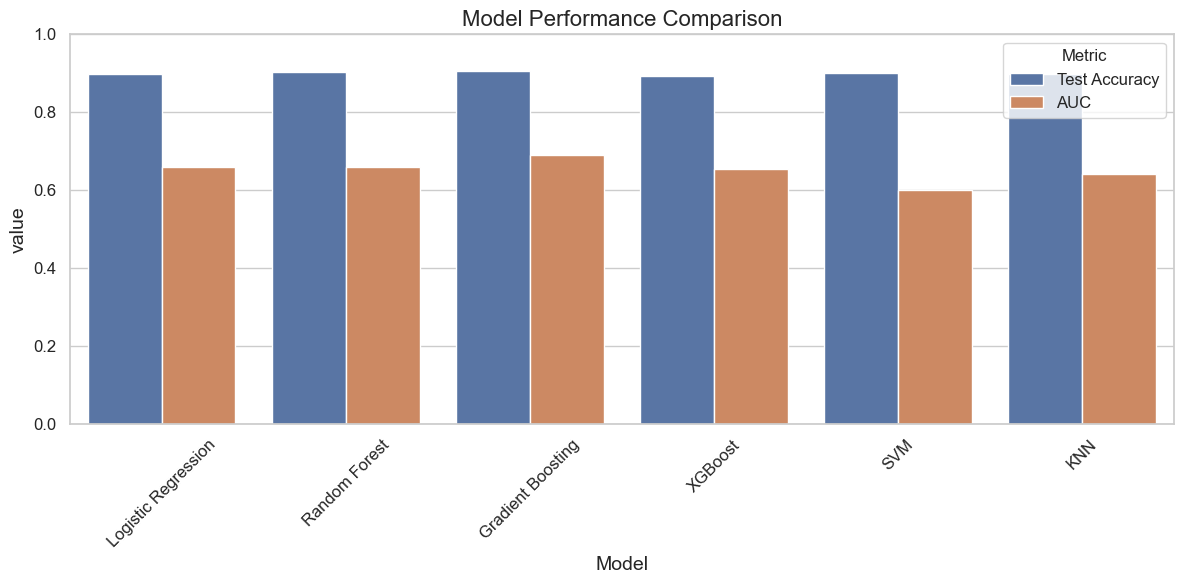


Best performing model: Gradient Boosting
Test Accuracy: 0.9063
AUC: 0.6912


In [13]:
## Model Training and Evaluation

# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier()
}

# Dictionary to store results
model_results = {}
model_pipelines = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Evaluate
    results = evaluate_model(pipeline, X_train, y_train, X_test, y_test)
    print(f"{name} - Test Accuracy: {results['test_accuracy']:.4f}, AUC: {results['auc']:.4f}")
    
    # Store results and pipeline
    model_results[name] = results
    model_pipelines[name] = pipeline

# Compare model performance
plot_model_comparison(model_results)

# Select the best performing model based on AUC
best_model_name = max(model_results, key=lambda k: model_results[k]['auc'])
best_model = model_pipelines[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Test Accuracy: {model_results[best_model_name]['test_accuracy']:.4f}")
print(f"AUC: {model_results[best_model_name]['auc']:.4f}")


In [14]:
## Detailed Analysis of Best Model

# Classification report
y_pred = best_model.predict(X_test)
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred))



Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.74      0.13      0.22       110
           1       0.91      0.99      0.95       968

    accuracy                           0.91      1078
   macro avg       0.82      0.56      0.58      1078
weighted avg       0.89      0.91      0.88      1078



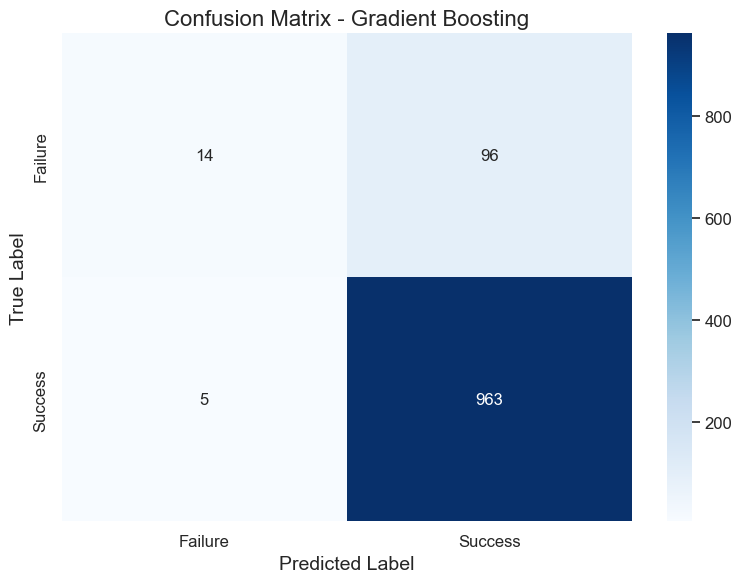

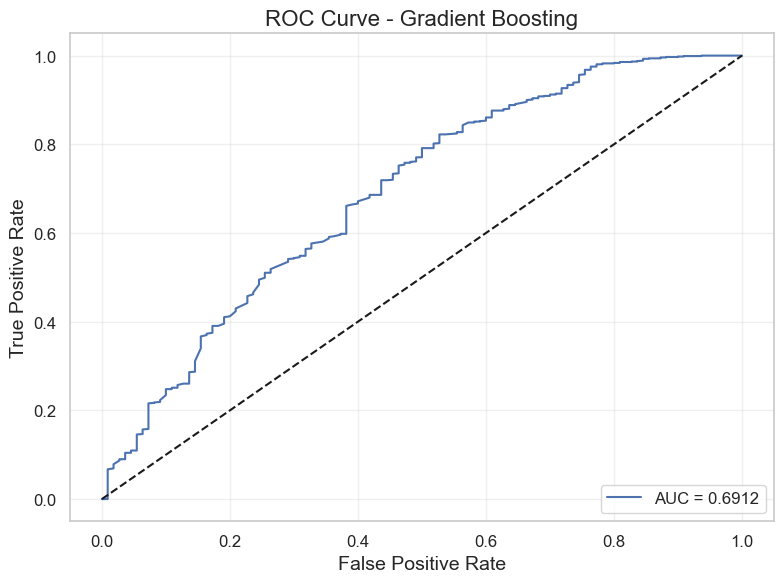

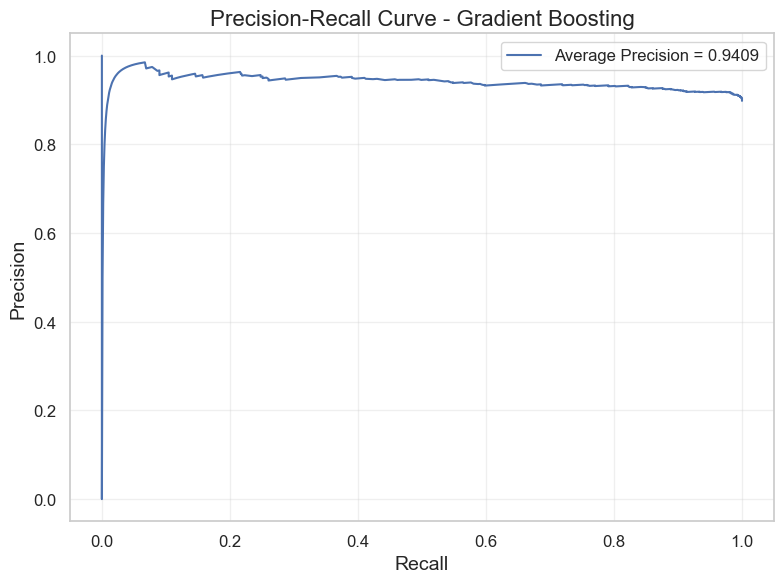

In [15]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC curve
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

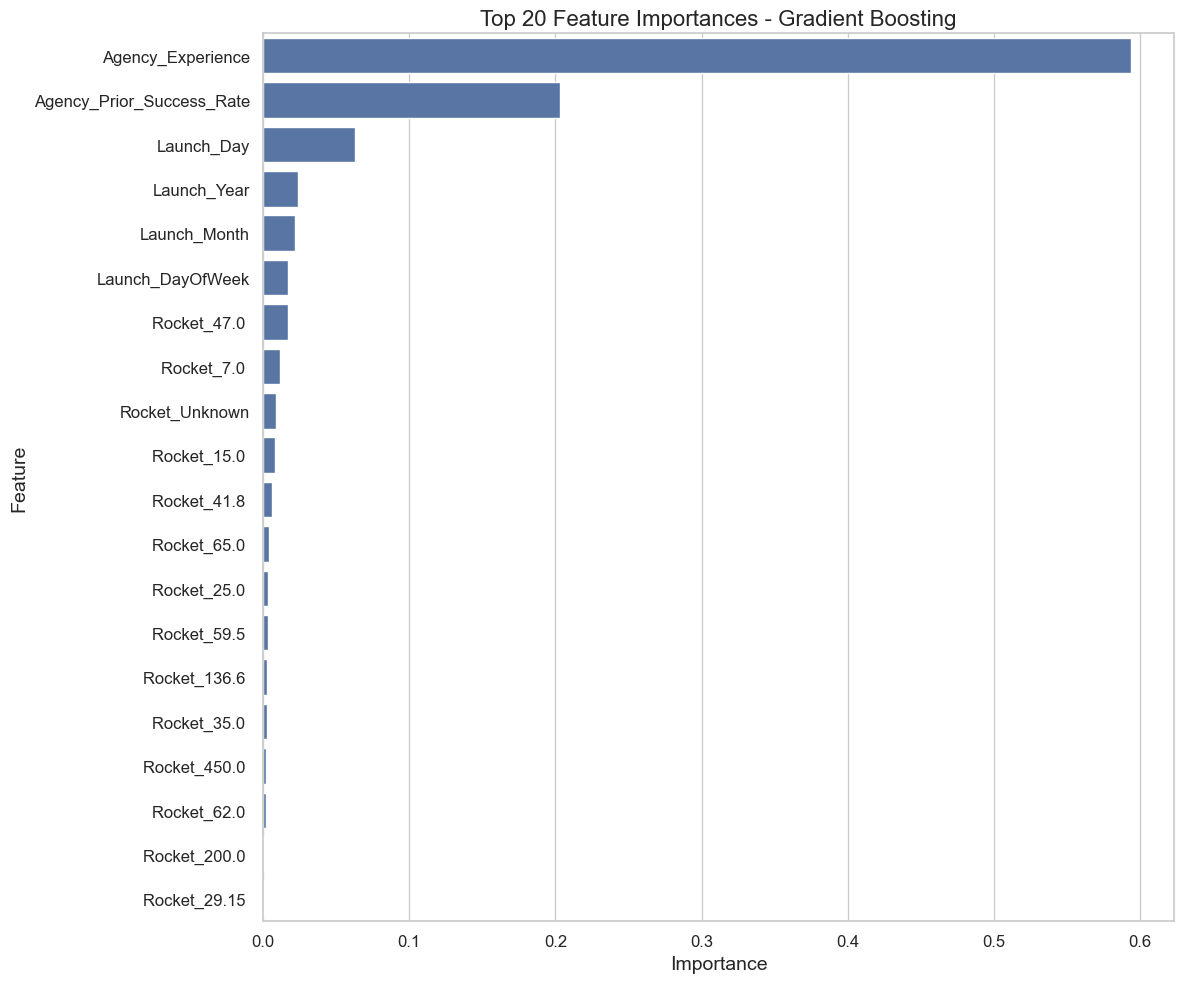


Top 10 Most Important Features:
Agency_Experience: 0.5935
Agency_Prior_Success_Rate: 0.2034
Launch_Day: 0.0630
Launch_Year: 0.0242
Launch_Month: 0.0219
Launch_DayOfWeek: 0.0174
Rocket_47.0 : 0.0173
Rocket_7.0 : 0.0115
Rocket_Unknown: 0.0089
Rocket_15.0 : 0.0079


In [16]:
## Feature Importance Analysis

# For tree-based models, analyze feature importance
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    # Get feature names after preprocessing
    cat_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
    feature_names = numerical_features + list(cat_features)
    
    # Get feature importances
    classifier = best_model.named_steps['classifier']
    
    if best_model_name == 'XGBoost':
        importances = classifier.feature_importances_
    else:
        importances = classifier.feature_importances_
    
    # Create DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    for i, row in feature_importance_df.head(10).iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
else:
    print("\nFeature importance analysis not available for the best model type.")



Performing hyperparameter tuning for Gradient Boosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}
Best cross-validation AUC: 0.6848

Tuned Gradient Boosting:
Test Accuracy: 0.9045
AUC: 0.6819


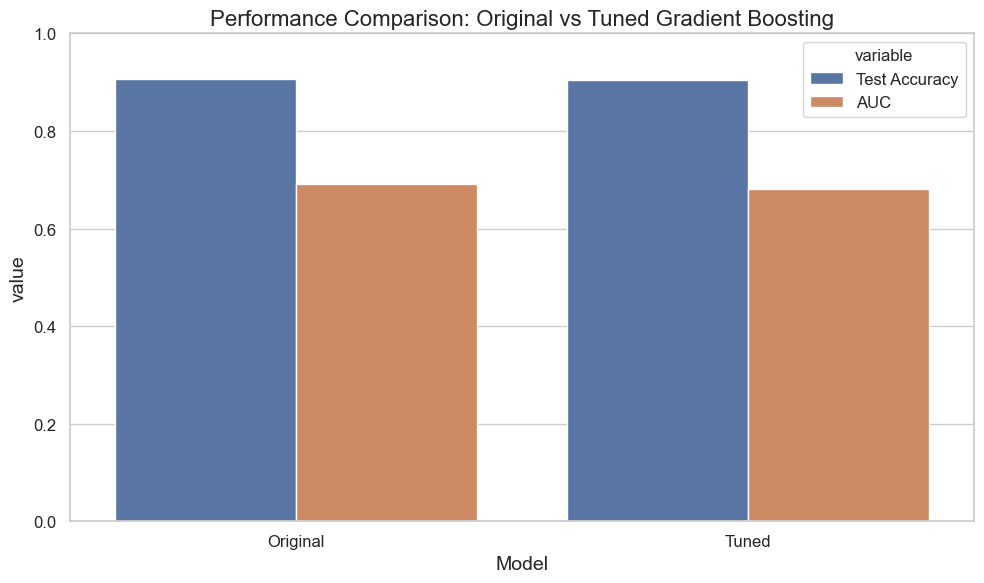


Model performance improvement:
Accuracy: -0.19%
AUC: -0.93%


In [17]:
## Hyperparameter Tuning for Best Model

print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

# Define parameter grid based on best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs'],
        'classifier__penalty': ['l1', 'l2']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 1.0]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto', 0.1, 0.01],
        'classifier__kernel': ['rbf', 'linear']
    }
elif best_model_name == 'KNN':
    param_grid = {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    }

# Create GridSearchCV
grid_search = GridSearchCV(
    best_model,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")

# Get the best model
tuned_model = grid_search.best_estimator_

# Evaluate tuned model
tuned_results = evaluate_model(tuned_model, X_train, y_train, X_test, y_test)
print(f"\nTuned {best_model_name}:")
print(f"Test Accuracy: {tuned_results['test_accuracy']:.4f}")
print(f"AUC: {tuned_results['auc']:.4f}")

# Compare original vs tuned model
comparison_data = pd.DataFrame({
    'Model': ['Original', 'Tuned'],
    'Test Accuracy': [model_results[best_model_name]['test_accuracy'], tuned_results['test_accuracy']],
    'AUC': [model_results[best_model_name]['auc'], tuned_results['auc']]
})

plt.figure(figsize=(10, 6))
comparison_plot = sns.barplot(x='Model', y='value', hue='variable', 
                              data=pd.melt(comparison_data, id_vars=['Model'], value_vars=['Test Accuracy', 'AUC']))
plt.title(f'Performance Comparison: Original vs Tuned {best_model_name}')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("\nModel performance improvement:")
print(f"Accuracy: {(tuned_results['test_accuracy'] - model_results[best_model_name]['test_accuracy']) * 100:.2f}%")
print(f"AUC: {(tuned_results['auc'] - model_results[best_model_name]['auc']) * 100:.2f}%")


In [18]:
## Save Best Model

# Save the final tuned model
joblib.dump(tuned_model, './output/models/space_mission_predictor.joblib')
print("\nFinal model saved to './output/models/space_mission_predictor.joblib'")

## Interactive Prediction Function

def predict_mission_success(agency, rocket, launch_year, launch_month, launch_day, cost=None, 
                          payload_mass=None, orbit=None, mission_purpose=None):
    """
    Predict the success probability of a space mission using our trained model.
    
    Parameters:
    -----------
    agency : str
        The space agency conducting the mission
    rocket : str
        The rocket used for the mission
    launch_year, launch_month, launch_day : int
        Components of the launch date
    cost : float, optional
        The mission cost in millions USD
    payload_mass : float, optional
        The payload mass in kg
    orbit : str, optional
        The target orbit
    mission_purpose : str, optional
        The purpose of the mission
    
    Returns:
    --------
    success_probability : float
        The probability of mission success
    """
    # Create a DataFrame for the input mission
    mission_data = pd.DataFrame({
        'Launch_Year': [launch_year],
        'Launch_Month': [launch_month],
        'Launch_Day': [launch_day],
        'Launch_DayOfWeek': [datetime(launch_year, launch_month, launch_day).weekday()],
        'Agency': [agency],
        'Rocket': [rocket],
        'Agency_Experience': [0],  # Placeholder, will be filled based on historical data
        'Agency_Prior_Success_Rate': [0.0]  # Placeholder, will be filled based on historical data
    })
    
    # Add optional features if provided
    if cost is not None:
        mission_data['Cost_Millions_USD'] = cost
    if payload_mass is not None:
        mission_data['Payload_Mass_kg'] = payload_mass
        # Create payload category
        bins = [0, 100, 500, 1000, 5000, float('inf')]
        labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
        mission_data['Payload_Category'] = pd.cut(mission_data['Payload_Mass_kg'], bins=bins, labels=labels)
    if orbit is not None:
        mission_data['Orbit'] = orbit
    if mission_purpose is not None:
        mission_data['Mission_Purpose'] = mission_purpose
    
    # Calculate agency experience and prior success rate
    if agency in agency_experience:
        mission_data['Agency_Experience'] = agency_experience[agency]
    if agency in agency_success_history:
        success_history = agency_success_history[agency]
        mission_data['Agency_Prior_Success_Rate'] = success_history[0] / success_history[1]
    
    # Make prediction
    success_prob = tuned_model.predict_proba(mission_data)[0, 1]
    
    return success_prob



Final model saved to './output/models/space_mission_predictor.joblib'


In [19]:
# Example usage
example_missions = [
    {
        'agency': 'NASA',
        'rocket': 'Falcon 9',
        'launch_year': 2023,
        'launch_month': 6,
        'launch_day': 15,
        'cost': 90,
        'payload_mass': 3000,
        'orbit': 'LEO'
    },
    {
        'agency': 'CASC',
        'rocket': 'Long March 5',
        'launch_year': 2023,
        'launch_month': 8,
        'launch_day': 2,
        'payload_mass': 8000,
        'orbit': 'GEO'
    },
    {
        'agency': 'SpaceX',
        'rocket': 'Falcon Heavy',
        'launch_year': 2023,
        'launch_month': 10,
        'launch_day': 20,
        'cost': 150,
        'payload_mass': 15000,
        'orbit': 'Mars Transfer'
    }
]

print("\nExample Mission Predictions:")
for i, mission in enumerate(example_missions):
    prob = predict_mission_success(
        agency=mission['agency'],
        rocket=mission['rocket'],
        launch_year=mission['launch_year'],
        launch_month=mission['launch_month'],
        launch_day=mission['launch_day'],
        cost=mission.get('cost'),
        payload_mass=mission.get('payload_mass'),
        orbit=mission.get('orbit'),
        mission_purpose=mission.get('mission_purpose')
    )
    print(f"Mission {i+1} ({mission['agency']} - {mission['rocket']}): {prob*100:.1f}% success probability")



Example Mission Predictions:
Mission 1 (NASA - Falcon 9): 74.2% success probability
Mission 2 (CASC - Long March 5): 82.2% success probability
Mission 3 (SpaceX - Falcon Heavy): 70.4% success probability


In [20]:
## Conclusion and Next Steps

print("\nConclusion:")
print("We have successfully built and evaluated multiple machine learning models for predicting space mission success.")
print(f"The best performing model is a tuned {best_model_name} with {tuned_results['auc']:.4f} AUC on the test set.")

print("\nNext Steps:")
print("1. Create an interactive dashboard for exploring mission success factors")
print("2. Incorporate additional features such as weather conditions during launch")
print("3. Develop a time series forecasting model for launch frequency prediction")
print("4. Analyze specific failure modes for different mission types")
print("5. Create a web application for real-time mission success prediction")


Conclusion:
We have successfully built and evaluated multiple machine learning models for predicting space mission success.
The best performing model is a tuned Gradient Boosting with 0.6819 AUC on the test set.

Next Steps:
1. Create an interactive dashboard for exploring mission success factors
2. Incorporate additional features such as weather conditions during launch
3. Develop a time series forecasting model for launch frequency prediction
4. Analyze specific failure modes for different mission types
5. Create a web application for real-time mission success prediction


In [21]:
# Save model metadata
model_metadata = {
    'Model_Type': best_model_name,
    'Training_Date': datetime.now().strftime('%Y-%m-%d'),
    'Features': numerical_features + categorical_features,
    'Test_AUC': tuned_results['auc'],
    'Test_Accuracy': tuned_results['test_accuracy']
}

pd.Series(model_metadata).to_csv('./output/models/model_metadata.csv')
print("\nModel metadata saved to './output/models/model_metadata.csv'")


Model metadata saved to './output/models/model_metadata.csv'
